In [2]:
%load_ext autoreload
%autoreload 2

%pylab inline

import numpy as np
from cartopy import crs, feature
import xarray as xr

from matplotlib import cm
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def reccap2_ocean_masks(url, dest):
    from pathlib import Path as posixpath
    import pooch
    
    fname = pooch.retrieve(url, None, posixpath(url).name, dest)
    ds = xr.open_dataset(fname)
    
    return ds


def get_southern_ocean_subregions(
    url='https://github.com/RECCAP2-ocean/RECCAP2-shared-resources/raw/master/data/regions/RECCAP2_region_masks_all_v20210412.nc',
    dest='../data/regions/'
):
    import pandas as pd
    import itertools
    
    ds = reccap2_ocean_masks(url, dest)

    mask = ds.southern
    
    atlantic = (((mask.lon > 290) | (mask.lon <=  20)) & (mask > 0)).astype(int) * 1
    indian   = (((mask.lon >  20) & (mask.lon <= 147)) & (mask > 0)).astype(int) * 2
    pacific  = (((mask.lon > 147) & (mask.lon <= 290)) & (mask > 0)).astype(int) * 3

    mask = xr.Dataset()
    mask['biomes'] = ds.southern.copy()
    mask['basins'] = (pacific + atlantic + indian).transpose('lat', 'lon')
    
    mask['subregions'] = (mask.basins * 3 + mask.biomes - 3).where(lambda a: a>0).fillna(0).astype(int)
    
    basin = ['ATL', 'IND', 'PAC']
    biome = ['STSS', 'SPSS', 'ICE']
    names = ['-'.join(l) for l in itertools.product(basin, biome)]    
    mask['names'] = xr.DataArray(names, coords={'idx': range(1, 10)}, dims=('idx'))
    mask['names'].attrs['description'] = 'Names for the subregions'
    
    mask['subregions'].attrs['description'] = '(basins * 3 + biomes - 3)'
    mask['basins'].attrs['description'] = 'Atlantic = 1, Indian = 2, Pacific = 3'
    mask['biomes'].attrs['description'] = 'Biomes based on Fay and McKinley (2014), STSS=1, SPSS=2, ICE=3'
    mask.attrs['source'] = url
    mask.attrs['date'] = pd.Timestamp.today().strftime('%Y-%m-%d')
    return mask



In [4]:
regions = get_southern_ocean_subregions().sel(lat=slice(-90, -34))
so = regions.subregions.where(lambda x: x!=0)

/Users/luke/opt/miniconda3/lib/python3.9/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
SHA256 hash of downloaded file: a5c8238c999cd336d29659f59dc137e2b5f606afd0af3108180ee38b6c0e3152
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [5]:
names = ['Atlantic STSS',
 'Atlantic SPSS',
 'Atlantic ICE',
 'Indian STSS',
 'Indian SPSS',
 'Indian ICE',
 'Pacific STSS',
 'Pacific SPSS',
 'Pacific ICE']

In [6]:
clist = np.array(cm.tab20c.colors)
colors = clist[[
    10, 9, 8,
    2, 1, 0, 
    6, 5, 4,
]].tolist()

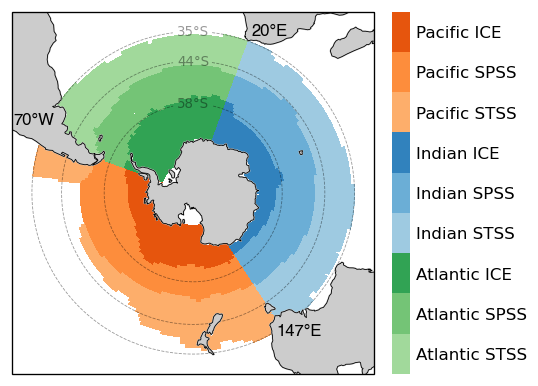

In [27]:
fig = plt.figure(figsize=[7.5, 4], dpi=120)
ax = fig.add_subplot(111, projection=crs.SouthPolarStereo())

img = so.plot.pcolormesh(
    ax=ax, transform=crs.PlateCarree(), 
    levels=np.arange(0.5, 10), 
    cbar_kwargs=dict(pad=0.025), 
    colors=colors, 
    rasterized=True)

ax.coastlines(lw=0.5, zorder=13)
ax.add_feature(feature.LAND, facecolor='#cccccc', zorder=12)

y = lambda lat: [lat] * x.size
for lat in [-35, -44, -58]:
    deg_size = np.cos(np.deg2rad(lat)) ** 1.5
    n_degs = (10 / deg_size) / 2
    x = np.arange(0 + n_degs, 360 - n_degs, 1)
    ax.plot(x, y(lat), transform=crs.PlateCarree(), color='k', lw=0.5, ls='--', alpha=0.4)
    ax.text(0, lat, f"{abs(lat)}°S", ha='center', va='center', transform=crs.PlateCarree(), size=8, alpha=0.4)

img.colorbar.set_ticks(np.arange(1, 10))
img.colorbar.set_ticklabels(names)
img.colorbar.set_label('')
[s.set_lw(0) for s in img.colorbar.ax.spines.values()]

props = dict(ha='left', va='center', transform=crs.PlateCarree(), zorder=14, size=10, weight='light', fontfamily='helvetica')
ax.text(149, -35, '147°E', **props)
ax.text(20, -32, '20°E', **props)
ax.text(292, -26, '70°W', **props)

ax.spines['geo'].set_zorder(14)
img.colorbar.ax.tick_params('both', length=0)

# fig.savefig('figure1_map.pdf', bbox_inches='tight', dpi=300)